# "One-dimensional" investigation

# 0 Imports

In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools

# 1 Text editing functions
The first few functions in this Python script pertain to editing or reading from the text files in LAMMPS. This could either be the logfile or the input script itself. 

I view these functions as the "fundamentals" in this code.

## 1.1 Extracting thermal conductivity from logfile
Log for thermal conductivity:

    print        "average conductivity: $k[W/mK] @ $T K, ${ndens} /A\^3"
    average conductivity: 0.316415655473469[W/mK] @ 70 K, 0.0257443666020476 /A\^3
    
so split the string such that we extract the number out only. Then the code checks to see if it contains that string (the thermal conductivity), and if it does, it filters it out. There's also a guard in case it doesn't find the thermal conductivity, which I guess is nice and can stop any potential errors.

In [2]:
def extract_TC(file_path):
    """Extracts the thermal conductivity (TC) value from the logfile,
    assuming that the LAMMPS script has already been run.
    Also takes their thermal conductivities
    
    Inputs:
    file_path - path to the logfile we want to read
    
    Outputs:
    thermal_conductivity - thermal conductivity extracted from the logfile (if it is there)
    k_x - thermal conductivity along the x direction extracted from logfile
    k_y - thermal conductivity along the y direction extracted from logfile
    k_z - thermal conductivity along the z direction extracted from logfile
    """
    
    # Open file in Python to read all lines
    with open(file_path, 'r') as file:
        content = file.read()

    # Looks for lines of the form {average conductivity: X[W/mk] @ 70 K, Y /A\^3}
    k_pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    # Search logfile for that line
    k_lines = k_pattern.findall(content)
    
    # If the line exists, extract thermal conductivity. Inform user if otherwise
    if len(k_lines)>0:
        thermal_conductivity = float(k_lines[0])
    else:
        return 'Thermal conductivity not found for this file'
    
    # Look for lines of the form {diretional thermal conductivites: k_x = kx, k_y = ky, k_z = kz}
    ki_pattern = re.compile(
        r'Directional thermal conductivities:\s*'
        r'k_x\s*=\s*(?P<kx>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_y\s*=\s*(?P<ky>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_z\s*=\s*(?P<kz>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)',
        re.IGNORECASE)
    
    # If the line exists, extract directional conductivity. Inform user if otherwise
    ki_lines = ki_pattern.findall(content)
    if ki_lines:
        kx_str, ky_str, kz_str = ki_lines[0]
        kx = float(kx_str)
        ky = float(ky_str)
        kz = float(kz_str)
    else:
        return 'Directional thermal conductivites not found for this file'
    
    return thermal_conductivity, kx, ky, kz

## 1.2 Updating the seed for the random velocities in LAMMPS
This must be the 'consideration of many seeds' that we were talking about. I'm assuming that taking many seeds for random generation would make the experiment more accurate. I like the idea.

In the LAMMPS input script (and actually the logfile too), we have the line

    velocity     all create $T 102486 mom yes rot yes dist gaussian

which initialises the velocities for the problem. The line of interest is the first line, which randomly generates the velocities from a normal distribution. The random generation seed is `102486` and we want to change this seed.

The one caveat is that this code assumes the velocity initialisation line is of the form

    velocity     all create $T $r mom yes rot yes dist gaussian

where `r` is a pre-defined seed, so `variable r equal {...}`. So I should be careful about that, but it's not much of a problem, all I would need to do is add a variable definition line.

Once again for my use case there is no reason to change this function, as my velocity initialisations should be the same.

In [3]:
def update_seed(file_path, new_seed):
    """Updates the seed for the velocity initialisation command in the LAMMPS input script.
    The velocity in LAMMPS is randomly initialised using a given seed.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_seed - new seed to be used in velocity initialisation
    
    Outputs:
    Updated file, if amendments have been made"""
    
    # Looks for lines of the form {variable r equal X}
    pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # If the pattern exists, update the line with the new seed in place
            if pattern.match(line):
                line = f"variable r equal {new_seed}\n"
            
            # Write the line to the file
            file.write(line)

## 1.3 Updating the masses of the atoms in LAMMPS input script
In the script/logfile, this will concern the line

    mass         1 {mass1}
    mass         2 {mass2}
    
so those two masses will be changed. Code below only does it for mass 1, but I imagine extending it for mass 2 would be super easy too. Functionally the code behaves exactly the same as the previous cell did, we target a specific line and replace it with something similar.

I amended Daniel's function slightly to account for the fact that both masses can be changed. This makes the function more general, but I don't know if I'd ever need to change both masses at the same time. Because the mass disorder should be relative between the masses.

In [4]:
def update_masses(file_path, new_mass1, new_mass2):
    """Updates the mass1 and mass2 variables in the LAMMPS input script.
    This assumes of course that the LAMMPS script concerns two fundamental atoms.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_mass1 - new mass 1 (g/mol)
    new_mass2 - new mass 2 (g/mol)
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Looks for lines of the form {mass    1 X} and {mass    2 Y}
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # --- Mass 1 ---
            # If the pattern exists, replace mass 1 with new_mass1
            if target_pattern_mass1.match(line):
                line = f"mass 1 {new_mass1}\n"
            # --- Mass 2 ---
            if target_pattern_mass2.match(line):
                line = f"mass 2 {new_mass2}\n"
                
            file.write(line)

## 1.4 Updating dimensonality of LAMMPS input script
One other thing which the LAMMPS input script has inside it is the dimensonality of the problem. This can be defined in a line like follows

    dimensonality X
    
where `X` would be either `2` or `3`. I anticipate that this project will be considering two-dimensional structures quite frequently. So, we will need to be able to change the dimensions in the LAMMPS input script very easily. The function below does exactly that, using the same pattern recognition techniques as above.

In [5]:
def update_dimensionality(file_path, new_dimension):
    """Updates the dimensionality written in the LAMMPS input script.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Look for lines of the form {dimension X}
    pattern = re.compile(r'^\s*dimension\s+(\d+)\b(?=\s*(?:#|$))')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        # Update any line which matches line pattern
        for line in lines:
            if pattern.match(line):
                line = f"dimension {new_dimension}\n"
            
            file.write(line)

# 1.5 Bash function
To run the LAMMPS input script, we need to pass in commands through the device's (Windows/MacOS) command line/prompt. This is relatively simple to do once, all that is needed is the following command

    lmp -in input.txt
    
The `lammps.sh` file, which can be run iteratively thanks to the defined function below, simply has two lines in it:

    #!/bin/bash
    lmp -in tc.txt > log_iteration_${i}.txt

so when we call this file in Python using `!bash` we automatically feed the command `lmp -in tc.txt` into the command prompt and this will be logged in `log.txt`.

To do this one would first need to install Git for their operating device: this adds the BASH emulation onto the device, which then must be further defined as an environment system variable.

In [6]:
def run_bash():
    """ I want to describe this better """
    !bash {'lammps.sh'}
    return

## 3.1 Creating a LAMMPS-compatible datafile

In [7]:
def layered_datafile_creation(Ncells, Nlayers, spacings):
    """Creates a datafile of an arbitrary crystallographic material which is LAMMPS compatible.
    Uses the generate_FCC function to generate FCC lattice.
    See the markdown above where this function is defined for details on the datafile structure.
    Alternativiely, view the eim example in LAMMPS.
    
    Inputs:
    
    Output:
    datafile.txt - datafile in LAMMPS format defining the structure"""

    # Find positions, types, IDs and group into data
    positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((IDs, atom_types, positions))

    # Will take the form [ID] [Type] [X1] [Y1] [Z1] column-repeated many times
    np.savetxt('datafile.txt', data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

{min(positions[:,0])} {max(positions[:,0]) + 0.5*spacings[0]} xlo xhi
{min(positions[:,1])} {max(positions[:,1]) + 0.5*spacings[1]} ylo yhi
{min(positions[:,2])} {max(positions[:,2]) + 0.5*spacings[2]} zlo zhi

Atoms
''', comments = '')
    
    return

In [8]:
def generate_FCC(Ncells, Nlayers, spacings):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes one type of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers"""
    # Create storage arrays
    positions1, positions2 = [], []
    atom_types1, atom_types2 = [], []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)

    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        # Check the first layer:
        if y%2 == 0:
            # Check if x+z is even
            if (x+z)%2 == 0:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2)*y_spacing
                # Append positions and types
                positions1.append([x,y,z])
                atom_types1.append(int(1))
                
        # Check the second layer
        elif y%2 == 1:
            # Check if x+z is odd
            if (x+z)%2 == 1:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2 + 0.5)*y_spacing
                # Append positions and types
                positions2.append([x,y,z])
                atom_types2.append(int(2))
                                    
    # Convert lists to arrays for plotting & return
    positions1 = np.array(positions1)
    positions2 = np.array(positions2)
    positions = np.concatenate( (positions1, positions2), axis=0 )
    atom_types1 = np.array(atom_types1)
    atom_types2 = np.array(atom_types2)
    atom_types = np.concatenate( (atom_types1, atom_types2), axis=0 )
    
    return positions, atom_types

We should check whether the periodic boundary conditions of this problem are correctly satisfied. In other words, that there are no unwanted gaps which may appear in the LAMMPS' simulation. These unwanted gaps can appear if the ratios between our type 1 and type 2 atoms are not both 50%.

Think about it like this:
In our fcc layering generation, we layered the types along the y-direction [010]. By virtue of the FCC structure this means that we have 5 type 1 atoms - 4 type 2 atoms - 5 type 1 atoms - ... etc. There's a clear discrepancy between the amount of type 1 and type 2 atoms. This means that if we were to employ this simple structure without considering anything else, this ratio wouldn't be 50% and we would therefore have gaps in our LAMMPS simulations. Essentially we add more type 2 atoms in their appropriate positions to get this ratio to reach 50%.

In [9]:
# Set up arbitrary number of cells, layers spacings
Ncells = np.array([3,3])
Nlayers = 5
spacings = np.array([5.376, 5.376, 5.376])
# Update masses (not needed for what we're doing here)
update_masses("tc.txt", 39.948, 100.0)

# Extract positions
positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)

# Count amount of occurences of type 1 and 2
atom_types = np.asarray(atom_types)
unique, counts = np.unique(atom_types, return_counts=True)
dict(zip(unique, counts))

{1: 90, 2: 90}

:)

## 1xNx1, but LAMMPS recognises as an ultrathin 3D object

In [11]:
# Investigate 2x2xn sizes, where n is the amount of layers
Ncells = np.array([1,1])
Nlayers = np.arange(2, 21).astype(int)
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

# Setup array storage
k_averages, k_errors = [], []
kx_averages, kx_errors = [], []
ky_averages, ky_errors = [], []
kz_averages, kz_errors = [], []

# Loop over increasing layers
for layers in tqdm(Nlayers):
    # Create datafile for LAMMPS to use
    layered_datafile_creation(Ncells, layers, spacings)
    # Update seeds
    seeds = np.random.randint(1,10000,5)
    # Thermal conductivites per layer
    k_run, kx_run, ky_run, kz_run = [], [], [], []
    # Loop over seeds
    for seed in seeds:
        update_seed("tc.txt", seed)
        run_bash()
        # Extract TC and directional TC
        k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
        # Store all seed TC's
        k_run.append(k_seed)
        kx_run.append(kx_seed)
        ky_run.append(ky_seed)
        kz_run.append(kz_seed)
    # Find all TC averages per layer
    k_averages.append(np.mean(k_run))
    kx_averages.append(np.mean(kx_run))
    ky_averages.append(np.mean(ky_run))
    kz_averages.append(np.mean(kz_run))
    # Also find their errors
    k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
    kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
    ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
    kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [22:14<00:00, 70.24s/it]


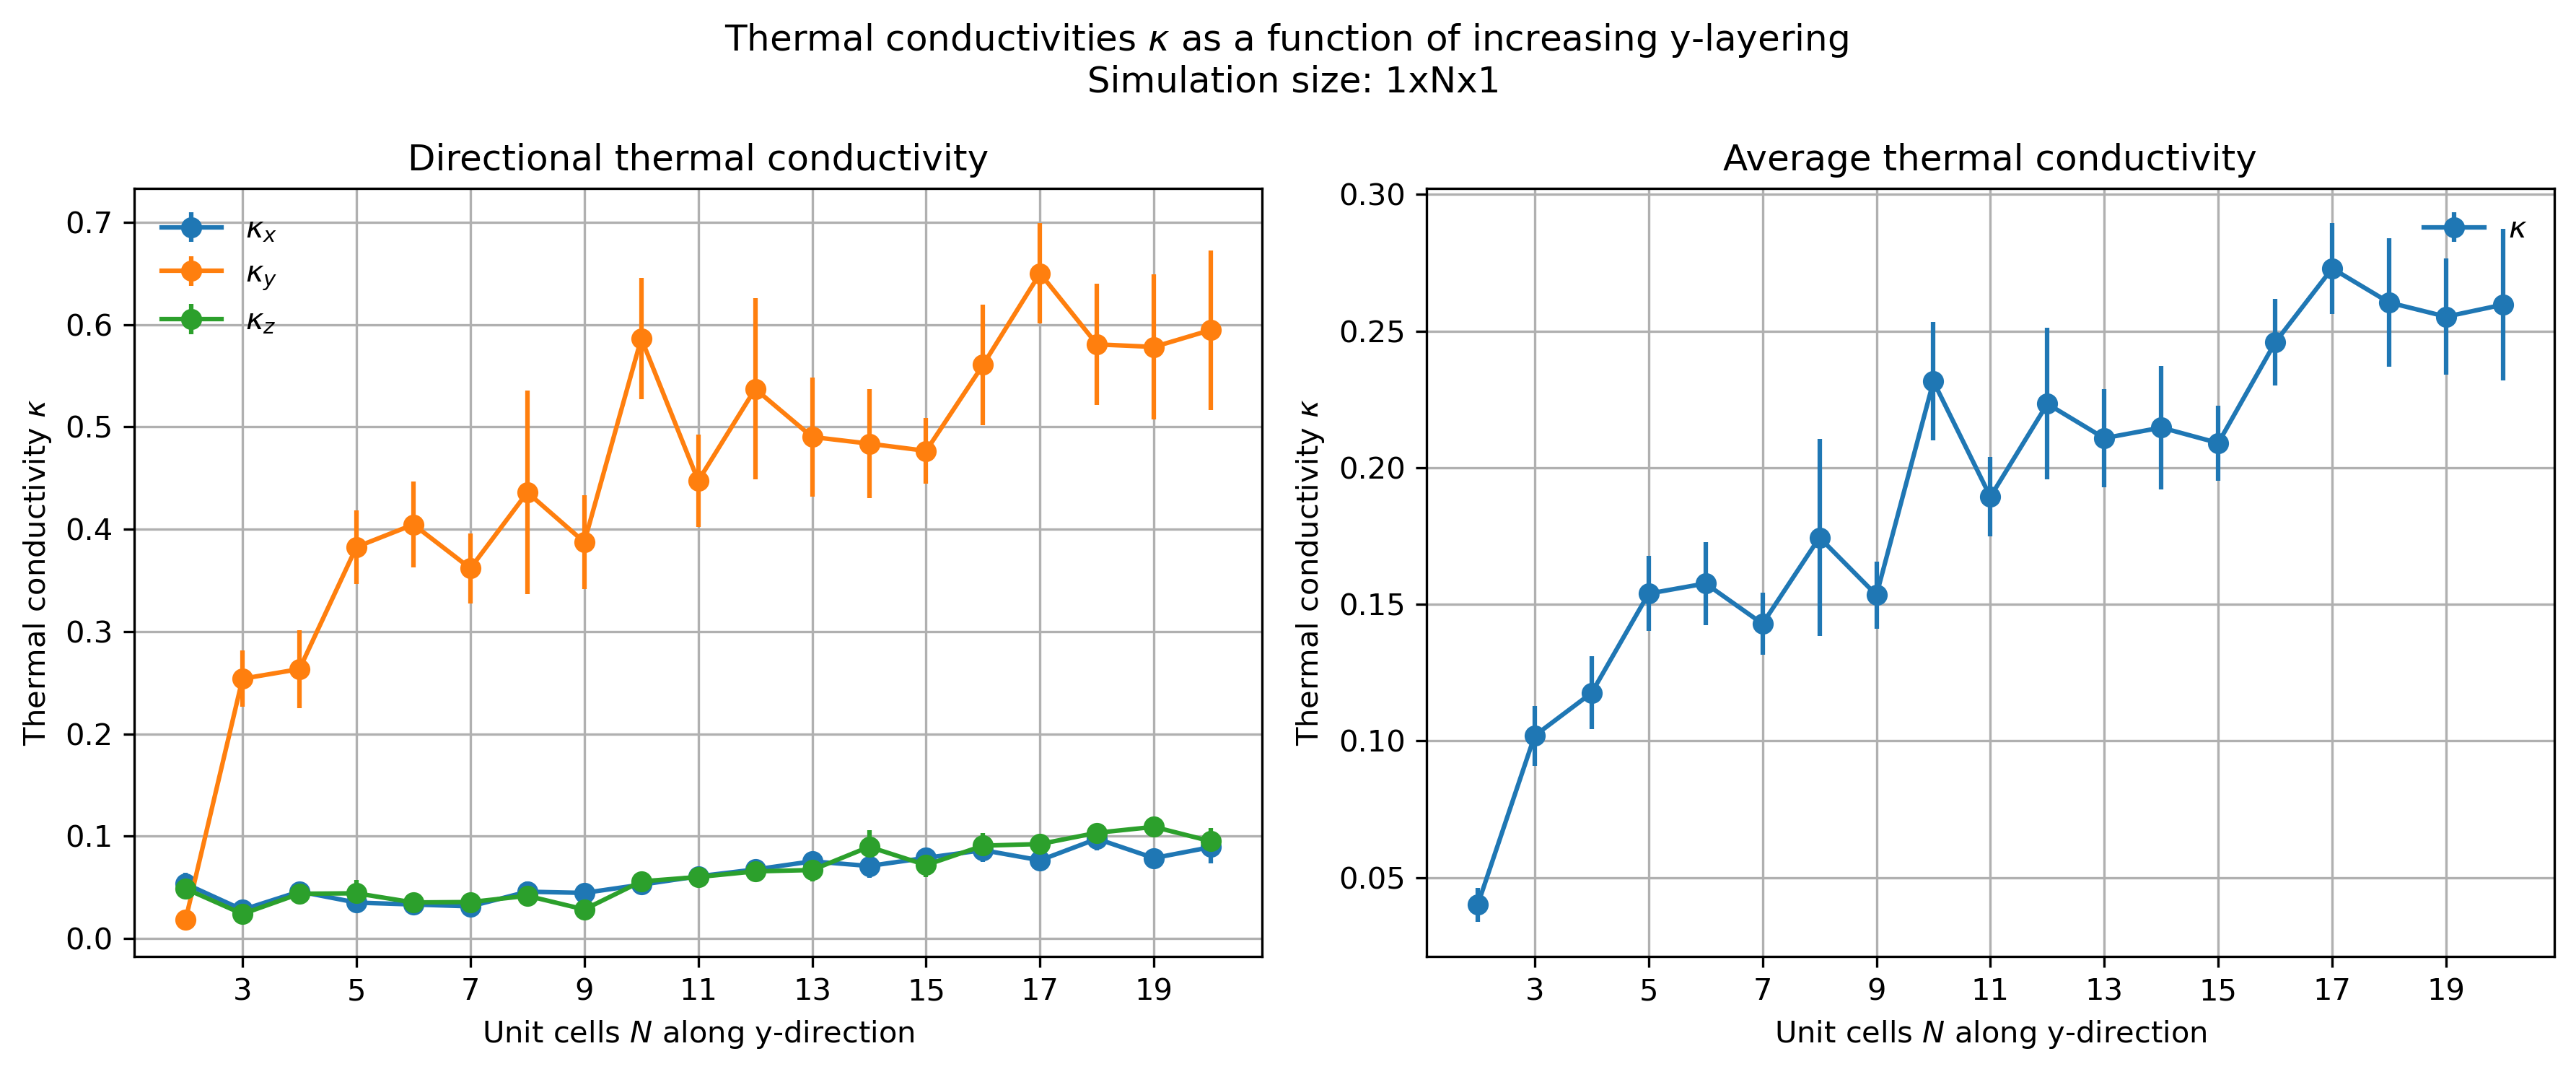

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot directional conductivities
ax1.errorbar(Nlayers, kx_averages, yerr=kx_errors, fmt='o-', label=r"$\kappa_x$")
ax1.errorbar(Nlayers, ky_averages, yerr=ky_errors, fmt='o-', label=r"$\kappa_y$")
ax1.errorbar(Nlayers, kz_averages, yerr=kz_errors, fmt='o-', label=r"$\kappa_z$")
ax1.set_xticks(Nlayers[1::2])
ax1.grid()
ax1.set_xlabel("Unit cells $N$ along y-direction"); ax1.set_ylabel("Thermal conductivity $\kappa$")
ax1.set_title("Directional thermal conductivity")
ax1.legend()

# Plot average conductivities
ax2.errorbar(Nlayers, k_averages, yerr=k_errors, fmt='o-', label=r"$\kappa$")
ax2.set_xticks(Nlayers[1::2])
ax2.grid()
ax2.set_xlabel("Unit cells $N$ along y-direction"); ax2.set_ylabel("Thermal conductivity $\kappa$")
ax2.set_title("Average thermal conductivity")
ax2.legend()

plt.suptitle("Thermal conductivities $\kappa$ as a function of increasing y-layering \n Simulation size: 1xNx1")
plt.tight_layout()